# Car Price prediction project

<p align="left">
  <img src="https://amcdn.blob.core.windows.net/media/1/root/car-price-tag.jpg" width="450">
</p>


## Dataset

Cars dataset with features including make, model, year, engine, and other properties of the car used to predict its price.

<a name = '1'></a>
## 1 - EDA 

We will examine a dataset in order to study:

- the distribution of the target variable;
- the features in this dataset;
- the distribution of values across these features;
- the data quality;
- the number of missing values.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
df = pd.read_csv('data.csv')
display(df.head())
print(f"{len(df)} rows in dataset")


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


11914 rows in dataset


As we can see, this dataset contains several columns:

- **make** — car brand (BMW, Toyota, etc.);
- **model** — car model;
- **year** — year of manufacture;
- **engine_fuel_type** — type of fuel required by the engine (diesel, electric, etc.);
- **engine_hp** — engine power in horsepower;
- **engine_cylinders** — number of cylinders in the engine;
- **transmission_type** — type of transmission (automatic or manual);
- **driven_wheels** — drivetrain (front-wheel, rear-wheel, all-wheel);
- **number_of_doors** — number of doors in the car;
- **market_category** — market segment (premium, crossover, etc.);
- **vehicle_size** — vehicle size (compact, midsize, or large);
- **vehicle_style** — body style (sedan, convertible, etc.);
- **highway_mpg** — miles per gallon (mpg) on the highway;
- **city_mpg** — miles per gallon (mpg) in the city;
- **popularity** — number of mentions of the vehicle on Twitter;
- **msrp** — manufacturer’s suggested retail price.


For us, the most interesting column here is the last one: **MSRP** (the manufacturer’s suggested retail price, or simply the price).  
We will use it to predict car prices.


The **MSRP** column contains important information — it is our target variable **y**, which represents the value we aim to learn how to predict.  
One of the first steps in exploratory data analysis should always be to understand what the values of **y** represent.


In [3]:
# column name normalization
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(' ','_').strip() for x in df.columns]
df

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


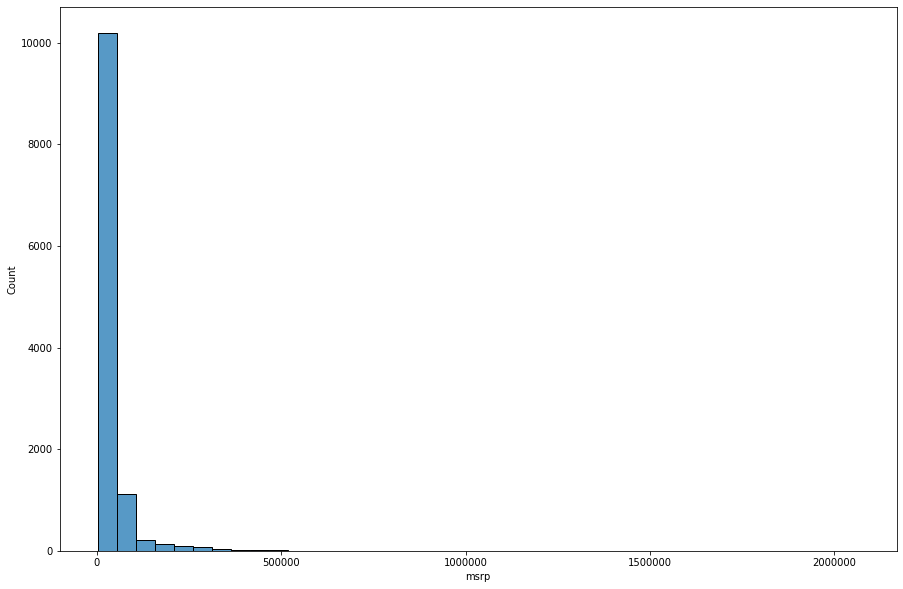

In [4]:
plt.figure(figsize=(15,10))
sns.histplot(df.msrp, bins=40)

plt.ticklabel_format(style='plain', axis='x')
plt.show()


Having plotted this graph, we immediately note that the price distribution has a very long "tail." On the left side, there are many cars with low prices, but their number quickly decreases, leaving a long "tail" of very few cars with high prices.  
  
We can see it from boxplot below that there are few cars that are extremely expensive.

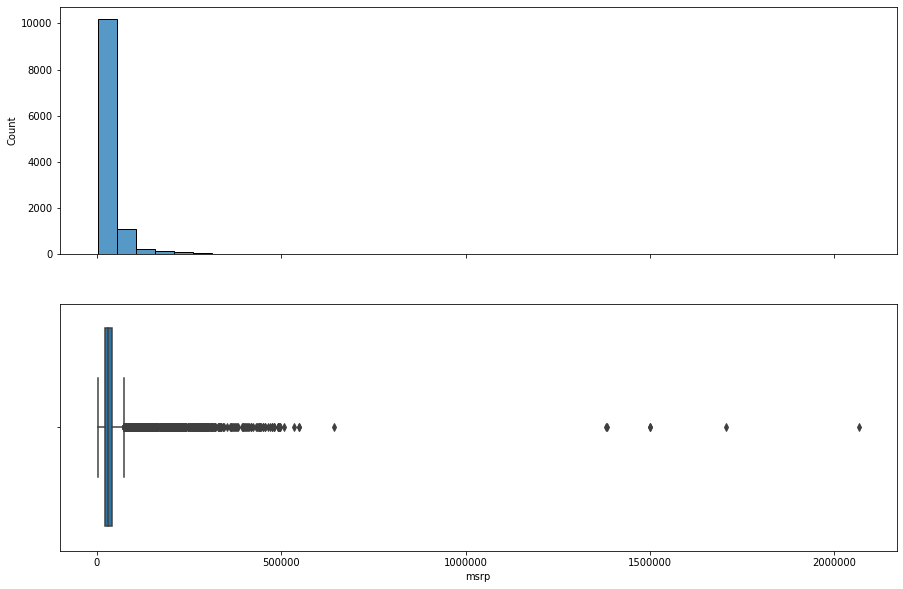

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.histplot(df.msrp, bins=40, ax=axes[0])
axes[0].set_ylabel("Count")

sns.boxplot(x=df.msrp, ax=axes[1])
axes[1].set_xlabel("msrp")
plt.ticklabel_format(style='plain', axis='x')
plt.show()


We can look at the details by zooming in a bit and selecting values ​​below $100,000.

<AxesSubplot: xlabel='msrp', ylabel='Count'>

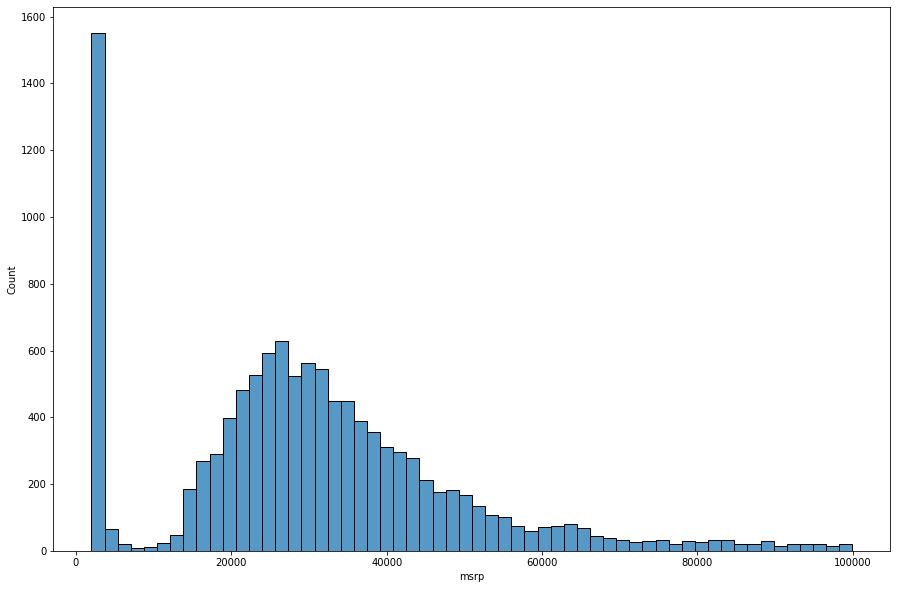

In [6]:
plt.figure(figsize=(15,10))
sns.histplot(df.msrp[df.msrp < 100000])

Due to the long tail, it is quite difficult to clearly observe the distribution.  
Moreover, this long tail has an even greater impact on the model: such a distribution can significantly confuse the model, leading to suboptimal training performance.

One way to address this issue is to apply a logarithmic transformation.  
By applying the `log` function to the prices, we remove this undesirable effect.

$$
y_{\text{new}} = \log(y + 1)
$$


<AxesSubplot: xlabel='msrp', ylabel='Count'>

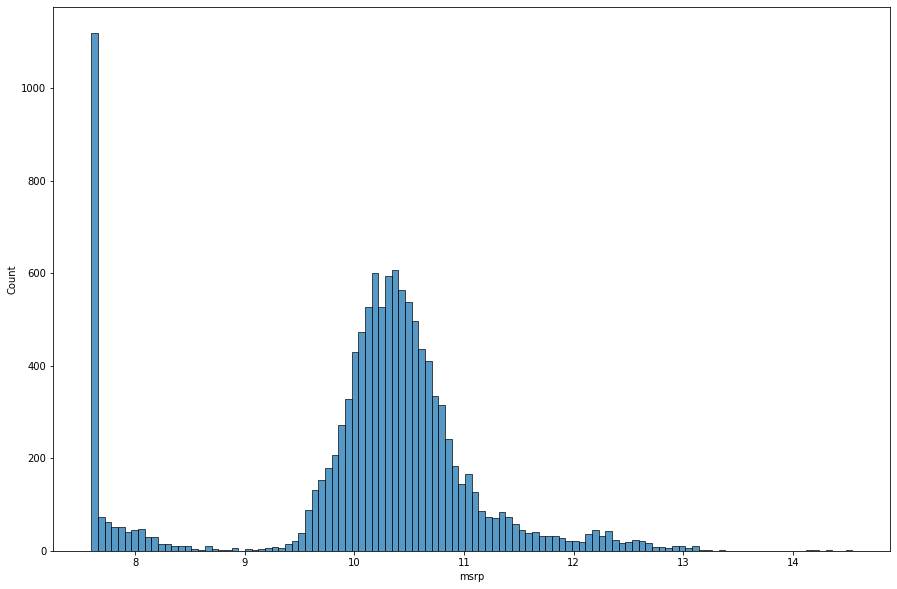

In [7]:
plt.figure(figsize=(15,10))
log_price = np.log1p(df.msrp)
sns.histplot(log_price)

### Checking for NULL or Missing values

We will examine other features more closely a bit later, but there is something we must do now — check the data for missing values. This step is important because machine learning models, as a rule, cannot automatically handle missing values. We need to find out if we will need to do anything special to process them

In [8]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

- **No missing values** found in `MSRP` (our target variable).
- This is a positive outcome, since missing target values would make records unusable for training.
- Several columns contain missing values.
- The most notable case is `market_category`, which has **almost 4,000 rows** with missing entries.



```markdown
Full dataset
     |
     +------------------+------------------+
     |                  |                  |
Training set     Validation set        Test set
     |                  |                  |
Training          Validation              Test


We will split dataset into three frames in our model:  
- **Validation** — 20 %
- **Testing** — 20 %
- **Training** — 60 %

In [9]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val+n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

At this point, the DataFrame has been split into three parts.  
Our initial analysis revealed a long tail in the price distribution, and to eliminate this effect, we need to apply a logarithmic transformation.  
We can perform this transformation separately for each DataFrame.


In [10]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

Removing the target variable is an optional step.  
However, it is important to ensure that we do not use it during model training: if this happens, we would be using the price to predict the price, and the model would show unrealistically perfect performance.


In [11]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

<a name = '2'></a>
## 2 - Machine Learning Regression 

After completing the initial data analysis, we are ready to train a model.  
The problem we are solving is a **regression task**: the goal is to predict a numerical value, namely the price of a car.  
For this project, we will use the simplest regression model — **linear regression**.


First, let us understand how linear regression works.  
As we know a supervised machine learning model has the following general form:

$$
y \approx g(X)
$$

This is a matrix formulation, where **X** is a matrix whose rows represent the feature vectors of observations, and **y** is a vector containing the values we want to predict.

Matrices and vectors can sometimes be confusing, so let us take a step back and consider what happens for a single observation \( x_i \) and the corresponding value \( y_i \) that we want to predict.  
The index \( i \) indicates that this is the *i-th observation*, one of the \( m \) observations in our training dataset.

For a single observation, the previous formula becomes:

$$
y_i \approx g(x_i)
$$

If we have \( n \) features, then the vector \( x_i \) is \( n \)-dimensional and consists of \( n \) components:

$$
x_i = (x_{i1}, x_{i2}, \ldots, x_{in})
$$

Since \( x_i \) has \( n \) components, we can express the function \( g \) as a function of \( n \) variables, which is consistent with the previous formulation:

$$
y_i = g(x_i) = g(x_{i1}, x_{i2}, \ldots, x_{in})
$$


In our case, the training dataset contains **7,150 cars**.  
This means that \( m = 7150 \), and the index \( i \) can take any value from **0 to 7,149**.

For example, when \( i = 10 \), we obtain the following car:


In [12]:
df_train.iloc[10]

make                                 Rolls-Royce
model                     Phantom Drophead Coupe
year                                        2015
engine_fuel_type     premium unleaded (required)
engine_hp                                  453.0
engine_cylinders                            12.0
transmission_type                      AUTOMATIC
driven_wheels                   rear wheel drive
number_of_doors                              2.0
market_category        Exotic,Luxury,Performance
vehicle_size                               Large
vehicle_style                        Convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 7557, dtype: object

Let us select a few numerical features and ignore the remaining ones for now.  
We can start with horsepower, city miles per gallon, and popularity:


Next, we assign these features to \( x_i1 \), \( x_i2 \), and \( x_i3 \), respectively.  
Thus, we obtain a feature vector \( x_i \) with three components:

$$
x_i = (x_{i1}, x_{i2}, x_{i3}) = (453, 11, 86)
$$


When we apply function **g** to the vector *x_i* it outputs **y_pred** as an output.  
Which is a forecast of **g** for *xi* 

The function \( g \) can take different forms, and the choice of the machine learning algorithm determines how it operates.

If \( g \) is a **linear regression model**, it has the following form:

$$
g(x_i) = g(x_{i1}, x_{i2}, \ldots, x_{in})
= w_0 + x_{i1} w_1 + x_{i2} w_2 + \ldots + x_{in} w_n
$$

The variables \( w_0, w_1, w_2, ..., w_n \) are the **model parameters**:

- \( w_0 \) — the bias (intercept) term;
- \( w_1, w_2, ..., w_n \) — the weights corresponding to each feature  
  \( x_i1, x_i2, ..., x_in \).


Let's make the formula shorter and cleaner

$$
g(x_i) = g(x_{i1}, x_{i2}, \ldots, x_{in}) = w_0 + \sum_{j=1}^{n} x_{ij} w_j
$$


Now we are ready to return to the big picture and discuss the **matrix form**.

The dataset contains many observations, and \( x_i \) represents one of them.  
Thus, we have \( m \) feature vectors \( x_1, x_2, ..., x_i, ..., x_m \), and each of these vectors consists of \( n + 1 \) features:

$$
x_1 = (1, x_{11}, x_{12}, \ldots, x_{1n})
$$

$$
x_2 = (1, x_{21}, x_{22}, \ldots, x_{2n})
$$

$$
\vdots
$$

$$
x_i = (1, x_{i1}, x_{i2}, \ldots, x_{in})
$$

$$
\vdots
$$

$$
x_m = (1, x_{m1}, x_{m2}, \ldots, x_{mn})
$$

We can stack these vectors together as rows of a matrix.


In linear algebra, this is a matrix–vector multiplication: we multiply the matrix \( X \) by the vector \( w \).  
As a result, the linear regression formula can be written as:

$$
g(X) = w_0 + Xw
$$
The result will be an array containing predictions for each row of the matrix \( X \).


<a name = '2.1'></a>
### 2.1 - Training for Linear Regression Model

So far, we have only considered prediction.  
In order to make predictions, we need to know the weights \( w \).  
How do we obtain them?

We learn the weights from the data: we use the target variable \( y \) to find such a vector \( w \) that best combines the features in \( X \).  
In the case of linear regression, “best” means that the error between the predictions \( g(X) \) and the true target values \( y \) is minimized.

There are several ways to achieve this.  
We will use the **normal equation**, which is the simplest method to implement.  
The weight vector \( w \) can be computed using the following formula:

$$
w = (X^T X)^{-1} X^T y
$$


- **\( X^T \)** — the transpose of matrix \( X \).  
  In NumPy, this is written as `X.T`.

- **\( X^T X \)** — matrix–matrix multiplication, which can be performed using the `dot` method in NumPy:  
  `X.T.dot(X)`.

- **\( (X^T X)^{-1} \)** — the inverse of the matrix \( X^T X \).  
  To compute the inverse, we can use the NumPy function `np.linalg.inv()`.


This is how normal equation should be realized in python
1. Create a function that takes a feature matrix \( X \) and a target vector \( y \).
2. Add a dummy column (a feature that always contains the value 1) to the matrix \( X \).
3. Train the model by computing the weights \( w \) using the normal equation.
4. Split the resulting vector \( w \) into the bias term \( w_0 \) and the remaining weights, and return them.


In [13]:
def train_linear_regression(X,y):
    #adding dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    # Normal equation form
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:] 

<a name = '2.2'></a>
### 2.2 - Price Prediction

We will start with a very naive approach to feature creation: we will select a few numerical features and construct the matrix \( X \) from them.  
In the previous example, we used only three features.  
This time, we will add a few more and use the following columns:

- **engine_hp**
- **engine_cylinders**
- **highway_mpg**
- **city_mpg**
- **popularity**


In [14]:
base = ['engine_hp','engine_cylinders','highway_mpg','city_mpg','popularity']
df_num = df_train[base]

As discussed earlier the dataset contains missing values.  
We need to address this issue because a linear regression model cannot automatically handle missing values.

One option is to remove all rows that contain at least one missing value.  
However, this approach has several drawbacks.  
Most importantly, we would lose information contained in other columns.  
Even if the number of doors is unknown, we can still obtain a lot of information about a car, such as its brand, model, age, and other characteristics that we do not want to lose.

Another option is to fill in the missing values with some other value.  
This way, we do not lose information in other columns and can still make predictions even if some values are missing in a row.  
The simplest possible approach is to fill missing values with zeros.


In [15]:
df_num = df_num.fillna(0)

Now we need to transform our dataframe into an array form.

In [16]:
X_train = df_num.values
X_train

array([[ 148.,    4.,   33.,   24., 1385.],
       [ 132.,    4.,   32.,   25., 2031.],
       [ 148.,    4.,   37.,   28.,  640.],
       ...,
       [ 285.,    6.,   22.,   17.,  549.],
       [ 563.,   12.,   21.,   13.,   86.],
       [ 200.,    4.,   31.,   22.,  873.]])

Let's calculate our weights and predict

In [17]:
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)


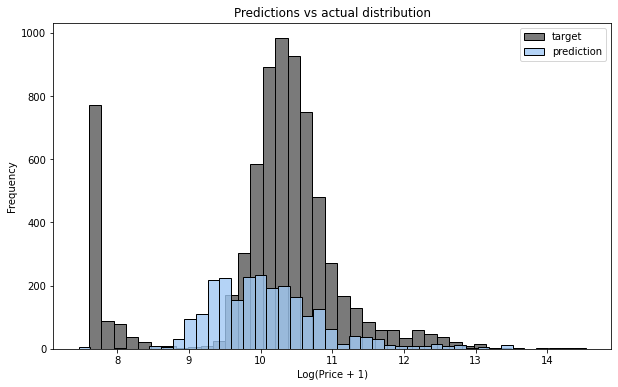

In [24]:
plt.figure(figsize=(10, 6))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#a1c9f4', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

<a name = '2.3'></a>
### 2.3 Evaluation of the Model **RMSE**

There are many metrics for evaluating how well a regression model performs.  
One of the most commonly used metrics is the **root mean squared error**, abbreviated as **RMSE** (root mean squared error).

RMSE tells us how large the errors made by the model are.  
It is computed using the following formula:

$$
\mathrm{RMSE} = \sqrt{\frac{1}{m} \sum_{i=1}^{m} \left( g(x_i) - y_i \right)^2}
$$

Let us try to understand what is happening here.  
First, consider the expression inside the summation:

$$
\left( g(x_i) - y_i \right)^2
$$


It is difference between predicted value and the actual target variable and then taking its square.  

Next, we have the sum:

$$
\sum_{i=1}^{m} \left( g(x_i) - y_i \right)^2
$$


Then we divide by *m* and this is the **mean squared error** that our model makes on average — the **M (mean)** component of the RMSE acronym, also known as **mean squared error (MSE)**.  
MSE is a good metric on its own.


Finally, we take the square root of the entire expression:

$$
\mathrm{RMSE} = \sqrt{\frac{1}{m} \sum_{i=1}^{m} \left( g(x_i) - y_i \right)^2}
$$

This corresponds to the **R (root)** component of the RMSE acronym.

In other words, RMSE is obtained by:
1. squaring the prediction errors,
2. computing their mean (MSE),
3. and then taking the square root.

As a result, RMSE has the same units as the target variable and is easier to interpret.


In [19]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [20]:
rmse(y_train, y_pred)

0.7554192603920132

Function outputs result of 0.76, this number tells us that on average model prediction deviates around 0.76.  
On it own, the result may not seem very useful, however, it can be used to compare with other models.

<a name = '2.4'></a>
### 2.4 Validation of the Model

In the example above, we computed RMSE on the training dataset.  
While this result is useful for understanding the model, it does not reflect how the model will be used in practice.

The model will be applied to predict car prices for vehicles it has not seen before.  
For this purpose, we previously created a **validation dataset**.  
We intentionally do not use it for training and keep it exclusively for model evaluation.

We have already split our data into several parts: **df_train**, **df_val**, and **df_test**.  
We also created the feature matrix **X_train** from **df_train** and used **X_train** together with **y_train** to train the model.

Now we need to perform the same steps to obtain **X_val** — a feature matrix computed from the validation dataset.  
Then, we can apply the model to **X_val** to generate predictions and compare them with **y_val**.


In [21]:
#We will create a function so that it can be reused 
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X


In [22]:
# Now entire flow will look as follows
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train,y_train)
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:',rmse(y_val, y_pred))

validation: 0.761653099130156


The `y_pred` array contains predictions for the validation dataset. Now we use `y_pred` and compare it with the actual values from `y_val` using the RMSE function that we implemented earlier:

*rmse(y_val, y_pred)*

The code returns a value of `0.76`, and this number should be used to compare models.
  
This allows us to check whether any adjustments to the model lead to an improvement in prediction quality. As the next step, we will add additional features and check whether this results in a lower RMSE.
